## Proximal Policy Optimazation: PPO  in pendulum

In [1]:
import gym

# 定义环境
class MyWrapper(gym.Wrapper):
  def __init__(self):
    env = gym.make('Pendulum-v1', render_mode='rgb_array')
    super().__init__(env)
    self.env = env
    self.step_n = 0
  
  def reset(self):
    state, _ = self.env.reset()
    self.step_n = 0
    return state
    
  def step(self, action):
    state, reward, terminated, truncated, info = self.env.step(action)
    done = terminated or truncated
    self.step_n += 1
    if self.step_n >= 200:
      done = True
    return state, reward, done, info 
  
env = MyWrapper()
env.reset()

array([-0.4408908,  0.8975608,  0.7809649], dtype=float32)

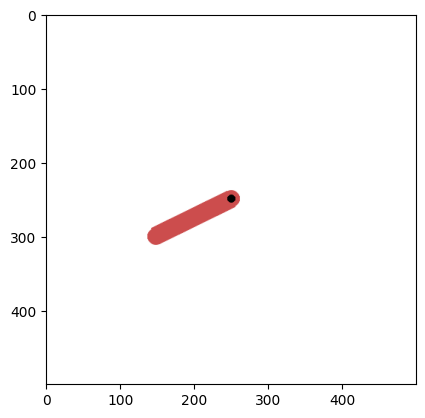

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline

# 打印游戏
def show():
  plt.imshow(env.render())
  plt.show()
  
show()

In [23]:
import torch

# 定义模型
class Model(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.fc_statu = torch.nn.Sequential(
      torch.nn.Linear(3, 128),
      torch.nn.ReLU(),
    )
    
    self.fc_mu = torch.nn.Sequential(
      torch.nn.Linear(128, 1),
      torch.nn.Tanh(),
    )
    
    self.fc_std = torch.nn.Sequential(
      torch.nn.Linear(128, 1),
      torch.nn.Softplus(),
    )
  
  def forward(self, state):
    state = self.fc_statu(state)
    
    mu = self.fc_mu(state) * 2.0
    std = self.fc_std(state)
    
    return mu, std

model = Model()

model_td = torch.nn.Sequential(
  torch.nn.Linear(3, 128),
  torch.nn.ReLU(),
  torch.nn.Linear(128, 1),
)

model(torch.randn(2, 3)), model_td(torch.randn(2, 3))

((tensor([[-0.5030],
          [-0.0853]], grad_fn=<MulBackward0>),
  tensor([[0.6284],
          [0.7128]], grad_fn=<SoftplusBackward0>)),
 tensor([[ 0.4088],
         [-0.0347]], grad_fn=<AddmmBackward0>))

In [25]:
import random

# 得到一个动作
def get_action(state):
  # 走神经网络，得到一个动作
  state = torch.FloatTensor(state).reshape(1, 3)
  mu, std = model(state)
  
  # 根据概率选择一个动作
  # action = random.choices(range(2), weights=prob[0].tolist(), k=1)[0]
  action = torch.distributions.Normal(mu, std).sample().item()
  
  return action

get_action([1, 2, 3])

-1.4535313844680786

In [26]:
# 得到一局游戏的数据
def get_data():
  states = []
  rewards = []
  actions = []
  next_states = []
  overs = []
  
  
  # 初始化游戏
  state = env.reset()
  
  # 玩到游戏结束为止
  over = False
  while not over:
    # 根据当前状态得到一个动作
    action = get_action(state)
    
    # 执行动作，得到反馈
    next_state, reward, over, _ = env.step([action])
    
    # 记录数据样本
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    next_states.append(next_state)
    overs.append(over)
    
    # 更新游戏状态，开始下一个动作
    state = next_state
    
  # [b, 3]
  states = torch.FloatTensor(states).reshape(-1, 3)
  # [b, 1]
  rewards = torch.FloatTensor(rewards).reshape(-1, 1)
  # [b, 1]
  actions = torch.FloatTensor(actions).reshape(-1, 1) # 注意此处类型有变化
  # [b, 3]
  next_states = torch.FloatTensor(next_states).reshape(-1, 3)
  # [b, 1]
  overs = torch.LongTensor(overs).reshape(-1, 1)
  
  return states, rewards, actions, next_states, overs

get_data()

(tensor([[-8.7202e-01, -4.8947e-01,  9.2292e-01],
         [-8.6310e-01, -5.0504e-01,  3.5887e-01],
         [-8.6503e-01, -5.0172e-01, -7.6774e-02],
         [-8.7565e-01, -4.8294e-01, -4.3167e-01],
         [-8.9138e-01, -4.5325e-01, -6.7200e-01],
         [-9.0970e-01, -4.1526e-01, -8.4360e-01],
         [-9.3040e-01, -3.6655e-01, -1.0586e+00],
         [-9.5116e-01, -3.0871e-01, -1.2292e+00],
         [-9.6936e-01, -2.4564e-01, -1.3131e+00],
         [-9.8411e-01, -1.7756e-01, -1.3934e+00],
         [-9.9476e-01, -1.0223e-01, -1.5220e+00],
         [-9.9976e-01, -2.1708e-02, -1.6140e+00],
         [-9.9827e-01,  5.8815e-02, -1.6112e+00],
         [-9.8998e-01,  1.4120e-01, -1.6565e+00],
         [-9.7630e-01,  2.1641e-01, -1.5293e+00],
         [-9.6224e-01,  2.7222e-01, -1.1513e+00],
         [-9.4782e-01,  3.1880e-01, -9.7526e-01],
         [-9.3466e-01,  3.5554e-01, -7.8070e-01],
         [-9.2618e-01,  3.7707e-01, -4.6272e-01],
         [-9.2187e-01,  3.8750e-01, -2.2568e-01],


In [27]:
from IPython import display

def test(play):
  #初始化游戏
  state = env.reset()
  
  #记录反馈值的和,这个值越大越好
  reward_sum = 0
  
  #玩到游戏结束为止
  over = False
  while not over:
    #根据当前状态得到一个动作
    action = get_action(state)
    
    #执行动作,得到反馈
    state, reward, over, _ = env.step([action])
    reward_sum += reward
    
    # 打印动画
    if play and random.random() < 0.2: # 跳帧
      display.clear_output(wait=True)
      show()
      
  return reward_sum

test(play=False)

-1766.454768297811

In [16]:
# 优势函数
def get_advantages(deltas):
  advantages = []
  
  # 反向遍历deltas
  s = 0.0
  for delta in deltas[::-1]:
    s = 0.9 * 0.9 * s + delta
    advantages.append(s)
    
  # 逆序
  advantages.reverse()
  return advantages

get_advantages(range(5))

[5.43839184, 6.7140640000000005, 7.0544, 6.24, 4.0]

In [28]:
def train():
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
  optimizer_td = torch.optim.Adam(model_td.parameters(), lr=5e-3)
  loss_fn = torch.nn.MSELoss()
  
  # 玩N局游戏，每句游戏训练一次
  for epoch in range(3000):
    # 玩一局游戏，得到数据
    # states -> [b, 3]
    # rewards -> [b, 1]
    # actions -> [b, 1]
    # next_states -> [b, 3]
    # overs -> [b, 1]
    states, rewards, actions, next_states, overs = get_data()
    
    # reward偏移
    rewards = (rewards + 8) / 8
    
    # 计算values, targets
    # [b, 3] -> [b, 1]
    values = model_td(states)
    
    # [b, 3] -> [b, 1]
    targets = model_td(next_states).detach()
    targets = targets * 0.98
    targets *= (1 - overs)
    targets += rewards
    
    # 计算优势,这里的advantages有点像是策略梯度里的reward_sum
    # 只是这里计算的不是reward,而是target和value的差
    # [b, 1]
    deltas = (targets - values).squeeze(dim=1).tolist()
    advantages = get_advantages(deltas)
    advantages = torch.FloatTensor(advantages).reshape(-1, 1)
    
    # 取出每步动作的概率
    # [b, 2] -> [b, 2] -> [b, 1]
    mu, std = model(states)
    # [b, 1]
    old_probs = torch.distributions.Normal(mu, std)
    old_probs = old_probs.log_prob(actions).exp().detach()
    
    # 每个批量反复训练10次
    for _ in range(10):
      #重新计算每一步动作的概率
      #[b, 3] -> [b, 1], [b, 1]
      mu, std = model(states)
      # [b, 1]
      new_probs = torch.distributions.Normal(mu, std)
      new_probs = new_probs.log_prob(actions).exp()
      
      # 求出概率变化
      # [b, 1] - [b, 1] -> [b, 1]
      ratios = new_probs / old_probs
      
      # 计算截断和不接段的两份loss, 取小的
      # [b, 1] * [b, 1] -> [b, 1]
      surr1 = ratios * advantages
      # [b, 1] * [b, 1] -> [b, 1]
      surr2 = torch.clamp(ratios, 0.8, 1.2) * advantages
      
      loss = -torch.min(surr1, surr2)
      loss = loss.mean()
      
      # 重新计算value和时序差分
      values = model_td(states)
      loss_td = loss_fn(values, targets)
      
      # 更新参数
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      optimizer_td.zero_grad()
      loss_td.backward()
      optimizer_td.step()
      
    if epoch % 200 == 0:
      test_result = sum([test(play=False) for _ in range(10)]) / 10
      print(epoch, test_result)
      
train()

0 -1739.3117925976894
200 -1085.5232947919362
400 -826.3066508478827
600 -882.5080211471862
800 -691.4920427538477
1000 -347.8187133169477
1200 -485.05654951946815
1400 -546.7858930448791
1600 -738.9169417773031
1800 -426.7886709942991
2000 -367.03985546771435
2200 -371.3735756140118
2400 -234.90072485005686
2600 -909.5412206000934
2800 -264.2937714404706


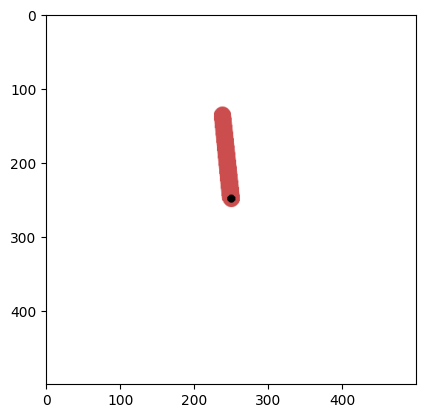

-269.50274624952914

In [31]:
test(play=True)